<a href="https://colab.research.google.com/github/dilaratank/roBERTa-Symptom-Tracking/blob/main/Symptom_Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## Motivation

The COVID-19 pandemic is a challenging time for all of us. AI-models in NLP could help process COVID-19 information in medical interviews more interpretable and visual. This research will focus on symptom extraction from medical dialogue before and after COVID-19.  

## RQs

What are the most common symptoms before and after COVID-19 in medical interviews? 

## Example as a task illustration

The code is designed to work as follows:
- Feed it a medical dialogue, where symptoms are discussed
- The code will extract the symptoms
- The code will display the most common symptoms in that conversation

An example can be illustrated with the following conversation: \
Patient: Hello doctor, these last few days I have been __coughing__ a lot. \
Doctor: That is unfortunate to hear, do you have any other symptoms like __sore throat__, __chest pains__, etc? \
Patient: I have a __cough__ and in addition to that also a __sore throat__, but that's about it. \
Doctor: Alright, a __cough__ and a __sore throat__ are symptoms of the Coronavirus but because of the time of year I assume you just have a __cold__. It is advised to take a test and take medicine for your __cough__ and __sore throat__. 

The model would then output 'cough' and 'sore throat' as most common symtpoms discussed in this dialogue. 

## Related literature
__Transformers__: A transformer model is used in Natural Language Processing (NLP) for sequence-to-sequence tasks such as language translation (Vaswani et al., 2017). Transformer models apply an attention mechanism, where the model determines which parts of an input sequence are important. This results in understanding relationships between all words in a sentence, without having to worry about their respective position. Transformers consist of an encoder that maps the input sequence into a higher dimensional space and a decoder that produces an output sequence, for example a translation of the input sequence. Because the encoder reads the whole input sequence at once, instead of reading the input from left to right or right to left, it is considered bidirectional. 

__BERT__: BERT (Bidirectional Encoder Representations from Transformers) is a language representation model that applies the bidirectional training of Transformers to language modelling (Devlin et al., 2018). Because of the bidirectionality, the model learns the context of a word based on all of its surroundings, instead of just the previous words. This allows for a deeper understanding of words and sentences. Using the fact that BERT can capture a deeper understanding of words and sentences, it can be applied to multiple NLP tasks by fine-tuning the model by adding a new layer on top of the model. The architecture of the new layer depends on the tasks one wants to do. 


__RoBERTa__: RoBERTa is an extension of the BERT model, it is trained longer and on more data, providing a stronger core model (Liu et al., 2019). For NLP tasks, adding an additional layer on top is still possible. 

__NER__: NER (Named Entity Recognition) tries to classify named entities mentioned in text to certain categories such as person, location, disease or symptom. It is explained before that a new layer is needed for the BERT or roBERTa model to perform NLP tasks. In the case of NER, this additional layer is a randomly initialized classifier (Vamvas, 2019). After training, this classifier outputs the most likely category of the words in the input sequence.  

# Experimental Setup

Let's first get access to all the data. 

In [1]:
!git clone https://github.com/dilaratank/roBERTa-Symptom-Tracking.git

Cloning into 'roBERTa-Symptom-Tracking'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 45 (delta 11), reused 22 (delta 7), pack-reused 0
Unpacking objects: 100% (45/45), done.


T-NER (https://github.com/asahi417/tner) is a python tool for language model finetuning on NER. It provides pre-trained RoBERTa models, including the pre-trained RoBERTa bc5cdr model. The bc5cdr dataset (Wei et al., 2015) consists of 1500 PubMed articles that are annotated for biomedical usage (chemicals, diseases, etc.). 

In [2]:
# Installations 
!pip install pip -U
!pip install sentencepiece
!pip install sortedcontainers==2.1.0
!pip install tner 

     |████████████████████████████████| 1.5MB 4.1MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 1.2 MB 4.1 MB/s 
  Attempting uninstall: sortedcontainers
    Found existing installation: sortedcontainers 2.3.0
    Uninstalling sortedcontainers-2.3.0:
      Successfully uninstalled sortedcontainers-2.3.0
     |████████████████████████████████| 2.2 MB 7.0 MB/s 
     |████████████████████████████████| 69 kB 6.8 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 125 kB 28.2 MB/s 
     |████████████████████████████████| 48 kB 5.2 MB/s 
     |████████████████████████████████| 11.6 MB 22.0 MB/s 
     |████████████████████████████████| 1.9 MB 50.3 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 59 kB 6.7 MB/s 
     |████████████████████████████████| 10.1 MB 43.2 MB/s 
     |██████

In [1]:
# Imports
import nltk
from nltk.tokenize import word_tokenize
from nltk import tokenize
nltk.download('punkt')
import pandas as pd
from pandas import DataFrame
import numpy as np
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import os

from tner import TransformersNER
from pprint import pprint

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Datasets

The following datasets will be used: 
- COVID-19 Dialogue Datase (during/after covid) https://www.kaggle.com/xuehaihe/covid-dialogue-dataset?select=COVID-Dialogue-Dataset-English.txt
- MedDialog Dataset (English) (before covid) https://github.com/UCSD-AI4H/Medical-Dialogue-System
  - This dataset consists of 4 datasets, the 'icliniq' dataset will be used for this project because of the wide variety of medical subjects

These datasets are structured as follows: 
- ID number
- Description
- Dialogue


### Dataset Preprocessing

The roBERTa model requires the data to be structured per sentence, which is done in the preprocessing steps. First, the data is split on dialogue to get rid of other unneccessary information. Thereafter, the data is split on sentences and saved as a .csv file for later use.

Preprocessing the data might take a while! Especially the icliniq dialogue.

In [2]:
def split_on_dialogue(data_path):
    """
    Returns list with conversations
    Format conversatoins: [[conversation1], [conversation2], ..., [conversation_n]]
    """

    with open(data_path) as f:
        lines = f.readlines()
        f.close()

    i = 0
    j = 0
    dialogue_i = 0
    convo = []
    conversations = []

    for line in lines:
        i += 1
        tokens = word_tokenize(line)

        if line[:8] == 'Dialogue':
            dialogue_i = i + 1

        if i == dialogue_i + j:
            convo.append(line)
            j += 1
            if len(tokens) == 0:
                conversations.append(convo)
                convo = []
                j = 0
                continue
    return conversations


def split_on_sentences(conversations):
    """
    A Function that splits the conversations in sentences.
    """

    sentence_list = []

    for conversation in conversations:
        for sentences in conversation:
            token_sen = tokenize.sent_tokenize(sentences)
            for sentence in token_sen:
                if sentence != 'Patient:' and sentence != 'Doctor:':
                    sentence_list.append(sentence)

    return sentence_list


def save(df, save_preprocessed_dataframe_path, name):
    """
    Function that saves the created dataframe as a csv.
    """

    df.to_csv(save_preprocessed_dataframe_path + name + '.csv', index=False)


def preprocess_to_csv(data_path, save_to):
    """
    A function that preprocesses the data (so that it is displayed per sentence),
    and saves is as a .csv file for later use.
    """

    # Split on dialogue
    conversations = split_on_dialogue(data_path)

    # Split on sentence
    sentences = split_on_sentences(conversations)

    # Make dataframe and drop dubplicates
    df_sent = pd.DataFrame(np.array(sentences), columns=['sentences'])
    df_sent.drop_duplicates(keep='first', inplace=True)

    # Save
    name = os.path.basename(data_path)
    save(df_sent, save_to, name[:-4])

    print(name, 'done')

In [3]:
if not os.path.exists('/content/roBERTa-Symptom-Tracking/data_preprocessed/COVID-Dialogue-Dataset-English.csv'):
    preprocess_to_csv('/content/roBERTa-Symptom-Tracking/data/COVID-Dialogue-Dataset-English.txt', '/content/roBERTa-Symptom-Tracking/data_preprocessed')
if not os.path.exists('/content/roBERTa-Symptom-Tracking/data_preprocessed/icliniq_dialogue.csv'):
    preprocess_to_csv('/content/roBERTa-Symptom-Tracking/data/icliniq_dialogue.txt', '/content/roBERTa-Symptom-Tracking/data_preprocessed')

# Note: If you actually want to run the code, uncomment and run the following:
#preprocess_to_csv('/content/roBERTa-Symptom-Tracking/data/COVID-Dialogue-Dataset-English.txt', '/content/roBERTa-Symptom-Tracking/data_preprocessed')
#preprocess_to_csv('/content/roBERTa-Symptom-Tracking/data/icliniq_dialogue.txt', '/content/roBERTa-Symptom-Tracking/data_preprocessed')

The data now looks like this:

In [4]:
covid_dialogue_df = pd.read_csv('/content/roBERTa-Symptom-Tracking/data_preprocessed/COVID-Dialogue-Dataset-English.csv')
icliniq_dialogue_df = pd.read_csv('/content/roBERTa-Symptom-Tracking/data_preprocessed/icliniq_dialogue.csv')
covid_dialogue_df.head()

,sentences
0,"Hello doctor, I get a cough for the last few d..."
1,No raise in temperature but feeling tired with...
2,No contact with any Covid-19 persons.
3,It has been four to five days and has drunk a ...
4,Doctors have shut the OP so do not know what t...


Because the Icliniq dialogue data is 60 times larger than the COVID-19 dialogue data, it will be shortened to +/ 5500 sentences. For this purpose a saved .csv file will be used so that the results will not change (due to randomness). To run this code please remove '`if not os.path.exists(...)` etc'. If you run this code, do note that the dataframe will be different each time. 

In [5]:
if not os.path.exists('/content/roBERTa-Symptom-Tracking/data_preprocessed/icliniq_dialogue_short.csv'):
    np.random.seed(10)
    dfcopy = icliniq_dialogue_df.copy()
    remove_n = 263500
    drop_indices = np.random.choice(dfcopy.index, remove_n, replace=False)
    icliniq_dialogue_short_df = dfcopy.drop(drop_indices)
    icliniq_dialogue_short_df.to_csv('/content/roBERTa-Symptom-Tracking/data_preprocessed/icliniq_dialogue_short.csv')
icliniq_dialogue_short_df = pd.read_csv('/content/roBERTa-Symptom-Tracking/data_preprocessed/icliniq_dialogue_short.csv')

## Aproaches

- Use pre-trained roBERTa to extract symptoms from medical dialogue before and after COVID-19
- Display most common symtoms
- Model evaluation using accuracy score


## Implementation details

First, let's download the pretrained model from HuggingFace. If this doesn't work, please open this code in a google colab. 

In [6]:
trainer = TransformersNER('asahi417/tner-xlm-roberta-base-bc5cdr')

2021-03-05 08:22:49 INFO     *** initialize network ***
2021-03-05 08:22:50 INFO     Lock 140215673450256 acquired on /root/.cache/huggingface/transformers/0124765b07a64cb3f0ac20bbbd761216814f2b9c09a674cdbe80456bcf2bdf67.e4c80030dae24cfa048ac47270164fcf0f9a4195d0f6b80ef60c4addb6ef99c1.lock


2021-03-05 08:22:50 INFO     Lock 140215673450256 released on /root/.cache/huggingface/transformers/0124765b07a64cb3f0ac20bbbd761216814f2b9c09a674cdbe80456bcf2bdf67.e4c80030dae24cfa048ac47270164fcf0f9a4195d0f6b80ef60c4addb6ef99c1.lock


2021-03-05 08:22:51 INFO     Lock 140215668803024 acquired on /root/.cache/huggingface/transformers/e6eadd5421865c5385da0f6025fb245b696e7361cc42fcbd3545277be35d8b18.a8d18fe2c0dd434eb43b496d442bd760ec596e291ac729aab932a21831a7f123.lock


2021-03-05 08:24:33 INFO     Lock 140215668803024 released on /root/.cache/huggingface/transformers/e6eadd5421865c5385da0f6025fb245b696e7361cc42fcbd3545277be35d8b18.a8d18fe2c0dd434eb43b496d442bd760ec596e291ac729aab932a21831a7f123.lock


2021-03-05 08:24:45 INFO     Lock 140215667160848 acquired on /root/.cache/huggingface/transformers/166cead684ec8e91fecec97a1068c59e7c6ffe7beaad4d7e7ba158ceca112e65.71e50b08dbe7e5375398e165096cacc3d2086119d6a449364490da6908de655e.lock


2021-03-05 08:24:47 INFO     Lock 140215667160848 released on /root/.cache/huggingface/transformers/166cead684ec8e91fecec97a1068c59e7c6ffe7beaad4d7e7ba158ceca112e65.71e50b08dbe7e5375398e165096cacc3d2086119d6a449364490da6908de655e.lock


2021-03-05 08:24:49 INFO     Lock 140215665476880 acquired on /root/.cache/huggingface/transformers/d59be0bb47689ce53b31cea19550dfa37fdd443a6533f323f8cd17c670400e9d.0dc5b1041f62041ebbd23b1297f2f573769d5c97d8b7c28180ec86b8f6185aa8.lock


2021-03-05 08:24:49 INFO     Lock 140215665476880 released on /root/.cache/huggingface/transformers/d59be0bb47689ce53b31cea19550dfa37fdd443a6533f323f8cd17c670400e9d.0dc5b1041f62041ebbd23b1297f2f573769d5c97d8b7c28180ec86b8f6185aa8.lock


2021-03-05 08:24:50 INFO     Lock 140215665479760 acquired on /root/.cache/huggingface/transformers/e2122fba918701de224f3eb6b358d2b7d54aa1dcfbeaacf459ab23afe4a034c1.ce1ec7367d995911ec791a5762308b4e4bbda9dc206caca7636088f9c2bce1a2.lock


2021-03-05 08:24:51 INFO     Lock 140215665479760 released on /root/.cache/huggingface/transformers/e2122fba918701de224f3eb6b358d2b7d54aa1dcfbeaacf459ab23afe4a034c1.ce1ec7367d995911ec791a5762308b4e4bbda9dc206caca7636088f9c2bce1a2.lock


For the task of determining the most used symptoms in a healhcare dialogue, the function `get_symptoms_data(df)` has been designed. It consists of 5 steps that will be discussed. The steps are also commented in the function for easier understanding and following. 

While looping over the seperate sentences in the dataframe: \
__Step 1__: First, the prediction of the sentence is extracted using the function `trainer.predict()` that is part of the T-NER package. \
__Step 2__: Second, only the predicted symptoms are extracted using the costum function `get_predicted_symptoms(prediction)`. This function returns only the sympoms that are mentioned in the sentence by only selecting the predicted entities that are labelled 'disease'. \
__Step 3__: Then, all these symptoms are gathered and put in a different dataframe. Note that this layout is not structured by sentence. All the symptoms are placed seperately in the dataframe. \
__Step 4__: After that, a counter is applied to this dataframe. This allows to extract the top 5 used symptoms. \
__Step 5__: The top 5 used symptoms are extracted and plotted for easy observation. 

In [7]:
def get_predicted_symptoms(prediction):
    """
    This function takes in the prediction of a sentence of the pre-trained model 
    and returns the symptoms mentioned in that sentence.
    """
    
    symptoms = []
    
    # Check if there is a predicted entity
    if len(prediction[0]['entity']) > 0:
        number_of_entities = len(prediction[0]['entity'])
    
        # Loop over predicted entities and get symptoms (here called: disease)
        for i in range(number_of_entities):
            if prediction[0]['entity'][i]['type'] == 'disease':
                symptoms.append(prediction[0]['entity'][i]['mention'])
            
    return symptoms 

def get_symptoms_data(df):
    """
    This function takes a (preprocessed) dataframe as input, determines the predicted
    symptoms per phrase, and outputs a dictionary with the 5 most frequent symptoms used,
    while also plotting the counts of the words in a barplot. 
    
    The steps (1-5) are explained in the report. 
    """
    
    all_symptoms = []
    skipped_sentences = 0
    
    for ind in tqdm(df.index):
        sentence = df['sentences'][ind]
        
        # Padding is needed because algorithms is not used to small sentences
        if len(sentence) < 45:
            sentence = sentence+'...'
        
        # Step 1
        try:
            prediction = trainer.predict([sentence])
        except:
            skipped_sentences += 1
            continue
        
        # Step 2
        predicted_symptom = get_predicted_symptoms(prediction)
        predicted_symptom = [x.lower() for x in predicted_symptom]
        predicted_symptom = [x.split(', ')[0] for x in predicted_symptom]
        
        # Step 3
        for symptom in predicted_symptom:
            if symptom != 'coronavirus': # Remove 'coronavirus', because it is not a symptom
                all_symptoms.append(symptom)
            
    df_symptoms = DataFrame(all_symptoms,columns=['symptoms'])
    
    # Step 4
    count_symptoms = Counter()
    
    # Split on 'enter(\n)' so that grouped words stay 1 symptom
    df_symptoms['symptoms'].str.lower().str.split('\n').apply(count_symptoms.update) 

    # Most common symptoms: Step 5
    print('Skipped sentences: ', skipped_sentences)
    top5 = dict(count_symptoms.most_common(5))
    print(top5)
    plt.bar(range(len(top5)), list(top5.values()), align='center')
    plt.xticks(range(len(top5)), list(top5.keys()))
    plt.title('Most common symptoms')
    plt.show()
        

# Evaluation

## Metrics
The model will be evaluated using the accuracy metric. The T-NER package also included evaluation functions, but the accuracy function that is used for this research has ben designed from scratch. The reason for this is because the T-NER functions needed the data to be in a different format. It has been decided that pre-processing the code again, only for that purpose, was not optimal. The accuracy function that has been developed keeps track of the total number of symptoms and the number of correctly predicted sympoms. The number of correctly predicted symptoms are then divided by the total number of symptoms, which gives the accuracy score. 

In [8]:
def accuracy(df, trainer):
    """
    This function computes the accuracy score, given a dataframe.
    """
    number_of_symptoms = 0
    number_of_well_predicted = 0

    for ind in tqdm(df.index):

        sentence = df['sentences'][ind]

        # Padding is needed because algorithms is not used to small sentences
        if len(sentence) < 60:
            sentence = sentence + '...'

        prediction = trainer.predict([sentence])

        predicted_symptom = get_predicted_symptoms(prediction)
        predicted_symptom = [x.lower() for x in predicted_symptom]
        predicted_symptom = [x.split(', ')[0] for x in predicted_symptom]
        gt_symptom = df['symptoms'][ind]

        # If it's not nan
        if isinstance(gt_symptom, str):
            gt_list = gt_symptom.split(', ')

            # Keep track of symptoms
            for symptom in gt_list:
                number_of_symptoms += 1

                # Keep track of well predicted symptoms
                if symptom in predicted_symptom:
                    number_of_well_predicted += 1

    print('Ground truth symptoms: ', number_of_symptoms)
    print('Correctly predicted symptoms ', number_of_well_predicted)
    print('accuracy: ', number_of_well_predicted / number_of_symptoms)

In [9]:
covid_dialogue_ann_df = pd.read_csv('/content/roBERTa-Symptom-Tracking/annotated_data/COVID-Dialogue-Dataset-English-annotated.csv')
icliniq_dialogue_ann_df = pd.read_csv('/content/roBERTa-Symptom-Tracking/annotated_data/icliniq_dialogue_nodup_annotated.csv')

The evaluation data is annotated by hand. Per sentence, the symptoms in that sentence are added to another column in the same row of the dataframe. It looks like this:

In [10]:
covid_dialogue_ann_df.head()

,sentences,symptoms
0,"Hello doctor, I get a cough for the last few d...",cough
1,No raise in temperature but feeling tired with...,"raise in temperature, tired"
2,No contact with any Covid-19 persons.,NaN
3,It has been four to five days and has drunk a ...,NaN
4,Doctors have shut the OP so do not know what t...,NaN


This will take approximately 1 or 2 minutes per dataset.

In [11]:
print('-- COVID-19 Dialogue --')
accuracy(covid_dialogue_ann_df, trainer)
print()
print('-- Icliniq Dialogue --')
accuracy(icliniq_dialogue_ann_df, trainer)

  0%|          | 0/507 [00:00<?, ?it/s]

-- COVID-19 Dialogue --


  1%|          | 5/500 [00:00<00:11, 44.68it/s]

Ground truth symptoms:  303
Correctly predicted symptoms  239
accuracy:  0.7887788778877888

-- Icliniq Dialogue --


100%|██████████| 500/500 [00:11<00:00, 44.63it/s]

Ground truth symptoms:  201
Correctly predicted symptoms  167
accuracy:  0.8308457711442786


## Results

The results for COVID-19 dialogue: 

![](RQ1/most_common_symptoms_covid.png)

100%|██████████| 4273/4273 [01:36<00:00, 44.48it/s]


Skipped sentences:  21
{'pneumonia': 323, 'fever': 196, 'cough': 174, 'sore throat': 81, 'infection': 65}


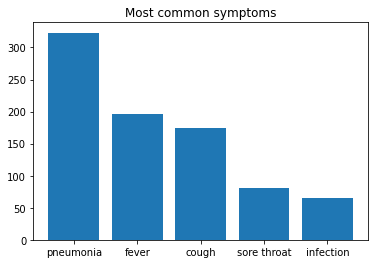

In [12]:
get_symptoms_data(covid_dialogue_df)

The results for Icliniq dialogue:

![](RQ1/most_common_symptoms_icliniq.png)

100%|██████████| 5678/5678 [02:07<00:00, 44.36it/s]


Skipped sentences:  19
{'pain': 188, 'anxiety': 46, 'bleeding': 44, 'fever': 40, 'infection': 33}


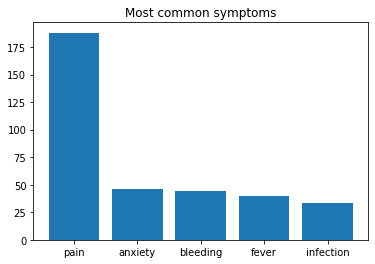

In [13]:
get_symptoms_data(icliniq_dialogue_short_df)

## Error analysis

# Findings

## Illustration

In the first plot (on the left) you can see the results for the COVID-19 dialogue again, and in the second plot (on the right) you can see the results for the Icliniq dialogue again. It can be seen that both results include the symptoms 'fever' and 'infection'. 

<table><tr><td><img src='RQ1/most_common_symptoms_covid.png'></td><td><img src='RQ1/most_common_symptoms_icliniq.png'></td></tr></table>

## Interpretation

The results show that pneumonia, fever, cough, sore throat and infection are the most common symptoms that patients and doctors talk about in COVID-19 related medical interviews. This seems valid, because they all actually are symptoms of COVID-19. Pneumonia is the most used symptom here, whereas before COVID-19 the most used symtpoms was pain. This is also seems valid, because in very general interviews (with general topics) pain can be used to describe a variety of areas. Furthermore, before COVID-19 the most used symptoms inclide anxiety, bleeding, fever and infection. 

It is clear that fever and infection were already important symptoms in medical interviews and with COVID-19 they stayed important, especially fever was more and more discussed. Furthermore, pain, anxiety and bleeding made way for pneumonia, cough and sore throat. 

## Discussion

The results can, of course, not be generalized to all medical interviews because just a sub-set of data is used for this research. However, it is still insightful to know the changes in medical dialogue before and after COVID-19. 

# Conclusions

## Summary

This research can be summarized as follows. To determine the most common symptoms in a medical dialogue before and after COVID-19 a pre-trained RoBERTa model is used to extract symptoms from a given sequence of text. These symptoms are then collected and counted, whereafter the top 5 most common sympoms are extracted and displayed. 

For this research it can be stated that the most common symptoms in COVID-19 symptoms dialogue are pneumonia, fever, cough, sore throat and infection. Whereas that used to be pain, anxiety, bleeding, fever and infection. Even though the results might not be generalized to all medical interviews out there, symptom-tracking could still be a useful tool for summarizing medical interviews or quickly displaying common symptoms for a certain disease. 

## Lessons learned

# References

Chih-Hsuan  Wei,  Yifan  Peng,  Robert  Leaman,  Al-lan  Peter  Davis,   Carolyn  J.  Mattingly,   Jiao  Li,Thomas   C.   Wiegers,    and   Zhiyong   Lu.   2015.Overview  of  the  BioCreative  V  Chemical  DiseaseRelation (CDR) Task.   InProceedings of the FifthBioCreative Challenge Evaluation Workshop. pages154–166.

Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2018). Bert: Pre-training of deep 
bidirectional transformers for language understanding. arXiv preprint arXiv:1810.04805.

Liu, Y., Ott, M., Goyal, N., Du, J., Joshi, M., Chen, D., ... & Stoyanov, V. (2019). Roberta: A robustly optimized bert pretraining approach. arXiv preprint arXiv:1907.11692.

Vamvas, J. (2019). BERT for NER. Von https://vamvas.ch/bert-for-ner.

Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. arXiv preprint arXiv:1706.03762.